In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge

In [ ]:
from google.colab import files

!rm -rf models.py
!rm -rf visualization.py
!rm -rf data_preparation.py
files.upload()

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import random
import cv2
import os

X, y = load_data()

X, y, num_outliers = delete_outliers(X, y)

# Split data into train_val and test sets
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

print(X_train.shape)
print(X_val.shape)
#print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(4503, 96, 96, 3)
(501, 96, 96, 3)
(array([0, 1]), array([2791, 1712]))
(array([0, 1]), array([310, 191]))


In [4]:
def explore_augmentation(augmentation, X, num_images=10):
  X_augmented = augmentation(X)

  fig, axes = plt.subplots(2, num_images, figsize=(20,4))
  for i in range(num_images):
      index = random.randint(0, len(X))
      ax = axes[0,i%num_images]
      ax.imshow(X[index])
      ax = axes[1,i%num_images]
      ax.imshow(X_augmented[index])
  plt.tight_layout()
  plt.show()

def increase_dataset(augmentation, X, y, increment):
  unhealthy = []
  for i, label in enumerate(y):
    if (label == 1):
      unhealthy.append(X[i])

  for i in range(increment):
    index = random.randint(0, len(unhealthy))
    aug = augmentation(unhealthy[index])
    index = random.randint(0, len(X))
    X = np.insert(X, index, aug, axis=0)
    y = np.insert(y, index, 1, axis=0)
  return X, y

def display_random_images(X, num_img=10, random=True):
  fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
  for i in range(num_img):
      if (random):
        image = random.randint(0, X.shape[0] - 1)
      else:
        image = i

      ax = axes[i%2, i%num_img//2]
      ax.imshow(np.clip(X[image], 0, 255))  # Display clipped item images
      ax.text(0.5, -0.1, str(image) + ' ' + str(y[image]), size=12, ha="center", transform=ax.transAxes)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

### PreTask

In [ ]:
def rotate_image(image):
    label = random.randint(0, 3)
    rotated = tf.image.rot90(image, k=label)
    return rotated, label

def pretask_dataset(X_train):
  X_gray = tf.image.rgb_to_grayscale(X_train).numpy()
  return X_gray

def build_pretask_model(input_shape, unfrozen_layers, dropout=0):
    # Create the base model for feature extraction
    mobile = tfk.applications.MobileNetV2(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet",
        #pooling='avg',
    )

    mobile.trainable = False

    print(mobile.output.shape)


    if (unfrozen_layers > 0):
      for layer in mobile.layers[-unfrozen_layers:]:
        #print(layer)
        layer.trainable = True

    input_tensor = tfkl.Input(shape=(96, 96, 1))
    x = tfkl.Conv2D(3, (3, 3), padding='same', name='FirstConv')(input_tensor)  # Convert grayscale to 3 channels
    x = mobile(x)
    #x = tfkl.Reshape((7, 7, 1280))(x)
    x = tfkl.Conv2D(256, (3, 3), activation='relu', padding='same', name='SecondConv')(x)
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(128, (3, 3), activation='relu', padding='same', name='ThirdConv')(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.UpSampling2D((4, 4))(x)
    x = tfkl.Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = tfkl.Dropout(dropout)(x)
    output_tensor = tfkl.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='ForthConv')(x)

    model = tfk.Model(inputs=input_tensor, outputs=output_tensor)

    # Compile the model
    model.compile(optimizer=tfk.optimizers.AdamW(), loss='mean_squared_error', metrics=[])

    return model

In [ ]:
X_pretask = pretask_dataset(X_train)
X_val_pretask = pretask_dataset(X_val)

print(X_pretask.shape)
print(X_val_pretask.shape)

(4503, 96, 96, 1)
(501, 96, 96, 1)


In [ ]:
display_random_images(X_pretask, random=False)
display_random_images(X_train, random=False)

In [ ]:
models = [
    build_pretask_model(X_pretask.shape[1:], 0, dropout=0),
    build_pretask_model(X_pretask.shape[1:], 0, dropout=0.2),
    build_pretask_model(X_pretask.shape[1:], 0, dropout=0.5),
]

histories = []

for model in models:
  history = model.fit(
        x = preprocess_input(X_pretask * 255),
        y = X_train,
        batch_size = 64,
        epochs = 200,
        validation_data = (preprocess_input(X_val_pretask * 255), X_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=20, min_lr=1e-5, mode='min')]
  ).history

  histories.append(history)



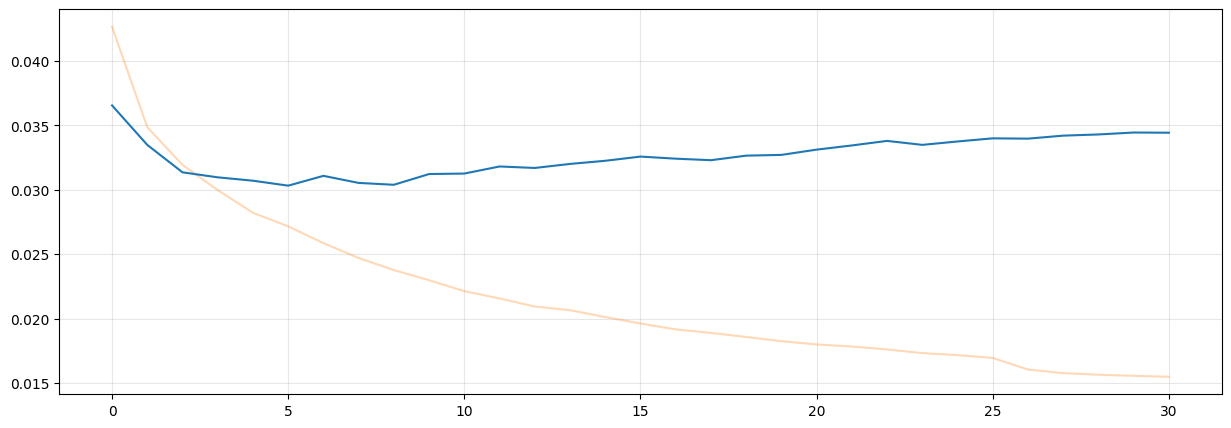

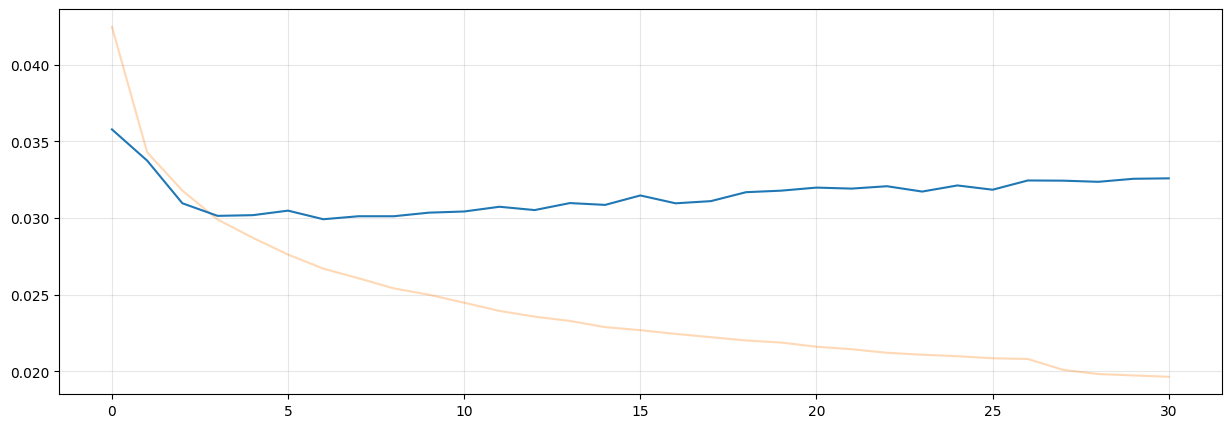

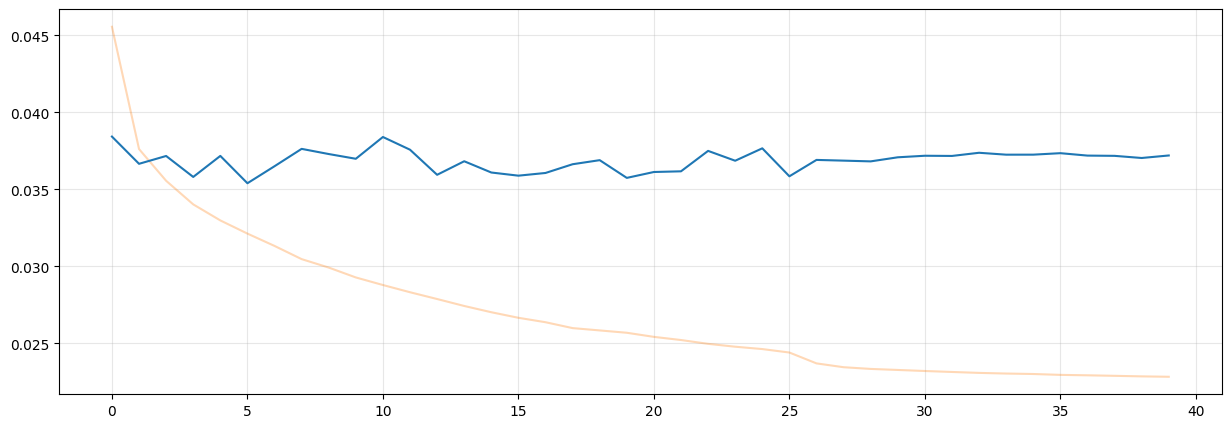

In [ ]:
for history in histories:
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], alpha=.3, color='#ff7f0e')
    plt.plot(history['val_loss'])
    #plt.title(name + ' Accuracy')
    plt.grid(alpha=.3)
    plt.show()

1/1 [==============================] - 0s 23ms/step


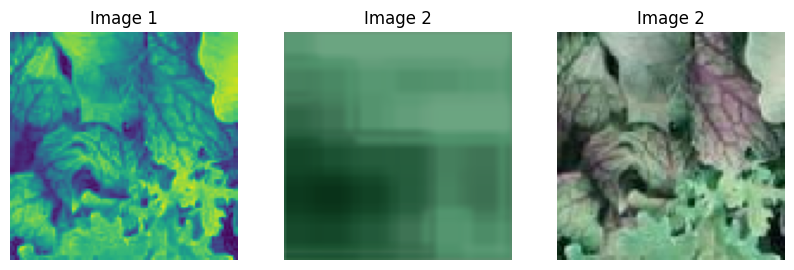

In [ ]:
index = random.randint(0, len(X_pretask))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(X_pretask[index])
axs[0].set_title('Image 1')
axs[0].axis('off')  # Turn off axis

predicted = models[2].predict(preprocess_input(np.expand_dims(X_pretask[index], axis=0)) * 255)

axs[1].imshow(predicted[0])
axs[1].set_title('Image 2')
axs[1].axis('off')  # Turn off axis

axs[2].imshow(X_train[index])
axs[2].set_title('Image 2')
axs[2].axis('off')  # Turn off axis

# Show the plot
plt.show()

### Model Building

In [7]:
#from tensorflow.keras.applications.mobilenet import preprocess_input
#from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)
tf.compat.v1.set_random_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

def get_block(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def build_model(input_shape, augmentation=tf.keras.Sequential([]), name="TransferModel", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=0, neurons=[]):
    #mobile = tfk.applications.MobileNetV2(
    #    input_shape=input_shape,
    #    include_top=False,
    #    weights="imagenet",
    #    pooling='avg',
    #)
    base_model = tfk.applications.EfficientNetB2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg'
    )

    base_model.trainable = False

    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    x = base_model(inputs)

    for n in neurons:
      x = get_block(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(model.summary())

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

### Validation and comparison

In [9]:
from sklearn.utils.class_weight import compute_class_weight

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      #tfkl.RandomFlip("horizontal_and_vertical"),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      #tf.keras.layers.RandomBrightness(0.3, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomBrightness(0.2, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    #tfkl.RandomTranslation(height_factor = (-0.5,0.5), width_factor = (-0.5,0.5), fill_mode = 'reflect'),
    #tfkl.RandomZoom(0.2, fill_mode = 'reflect'),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomRotation((-1,1), fill_mode = 'reflect'),
])
]

models = [
    build_model(X_train.shape[1:], neurons=[512], dropout=0.4, batch_normalization=True, learning_rate=5e-5, weight_decay=1e-6, name="Base", augmentation=augmentations[2]),
]

batch_size = 32

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = {
    0: weights[0],
    1: weights[1]
}

histories = []

for i, batch in enumerate(models):
  histories.append(
      models[i].fit(
        x = preprocess_input(X_train * 255),
        y = y_train,
        batch_size = batch_size,
        epochs = 200,
        class_weight = class_weights,
        validation_data = (preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=5e-6, mode='max')]
      ).history
  )

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb2 (Functional  (None, 1408)              7768569   
 )                                                               
                                                                 
 dense (Dense)               (None, 512)               721408    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0      

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


for i, history in enumerate(histories):
  predictions = models[i].predict(preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  #print(classification_report(y_val, predictions))
  print(roc_auc)
  #print(len(history['val_accuracy']) - 20)
  print(history['val_accuracy'][-21])
  print(history['accuracy'][-21])
  plot_history(history, models[i].name)

### Crossvalidation

In [ ]:
def crossvalidate(model, folds):
  # Define the number of folds for cross-validation

  # Initialize lists to store training histories, scores, and best epochs
  histories = []
  scores = []
  best_epochs = []

  initial_weights = model.get_weights()

  # Create a KFold cross-validation object
  kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    model.set_weights(initial_weights)

    # Train the model on the training data for this fold

    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y[train_idx]), y=y[train_idx])

    class_weights = {
        0: weights[0],
        1: weights[1]
    }

    history = model.fit(
          x = preprocess_input(X[train_idx] * 255),
          y = y[train_idx],
          batch_size = 64,
          class_weight=class_weights,
          epochs = 200,
          validation_data=(preprocess_input(X[valid_idx] * 255), y[valid_idx]),
          callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True, start_from_epoch=10),
            tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
    ).history


    histories.append(history)
    best_epochs.append(len(history['loss']) - 30)

  return histories, best_epochs

  # Evaluate the model on the validation data for this fold
  #score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
  #scores.append(score[1])

  # Calculate the best epoch for early stopping
  # Store the training history for this fold
  #histories.append(history)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      #tfkl.RandomFlip("horizontal_and_vertical"),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      #tf.keras.layers.RandomBrightness(0.3, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomBrightness(0.2, value_range=(0,1)),
  ])
]


models = [
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[0]),
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[1]),
]

histories = []
best_epochs = []

for i, model in enumerate(models):
  h, be = crossvalidate(model, 10)
  histories.append(h)
  best_epochs.append(be)

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_12 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0      

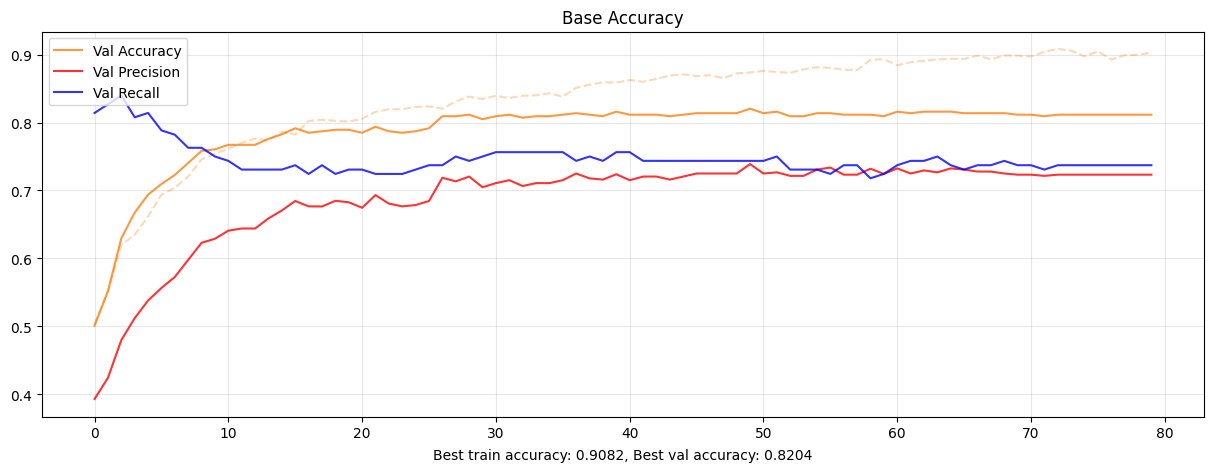

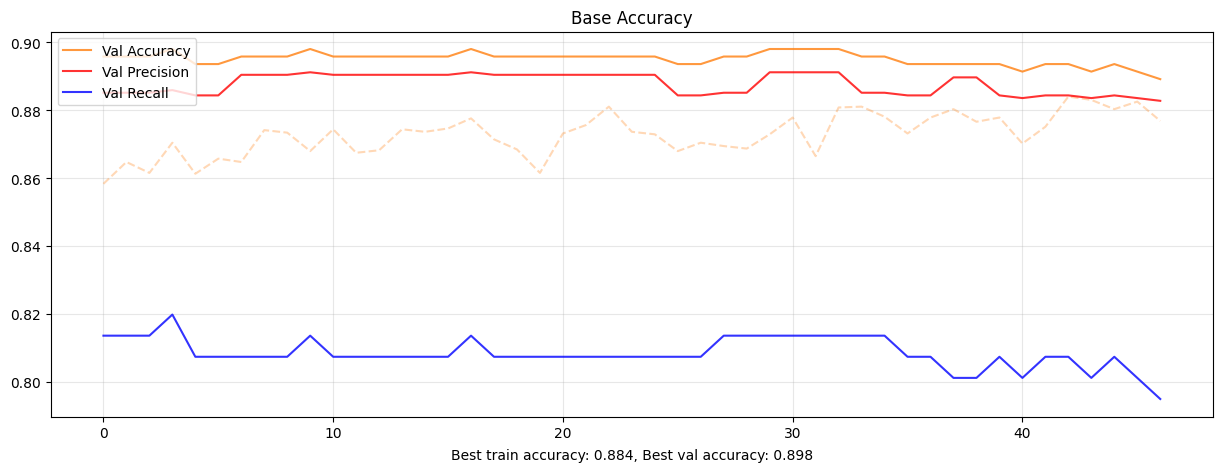

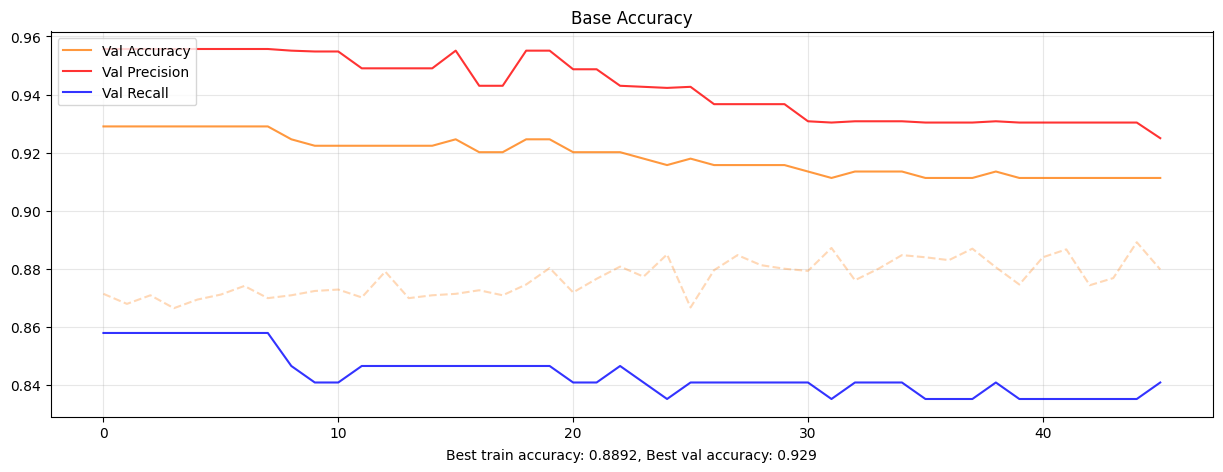

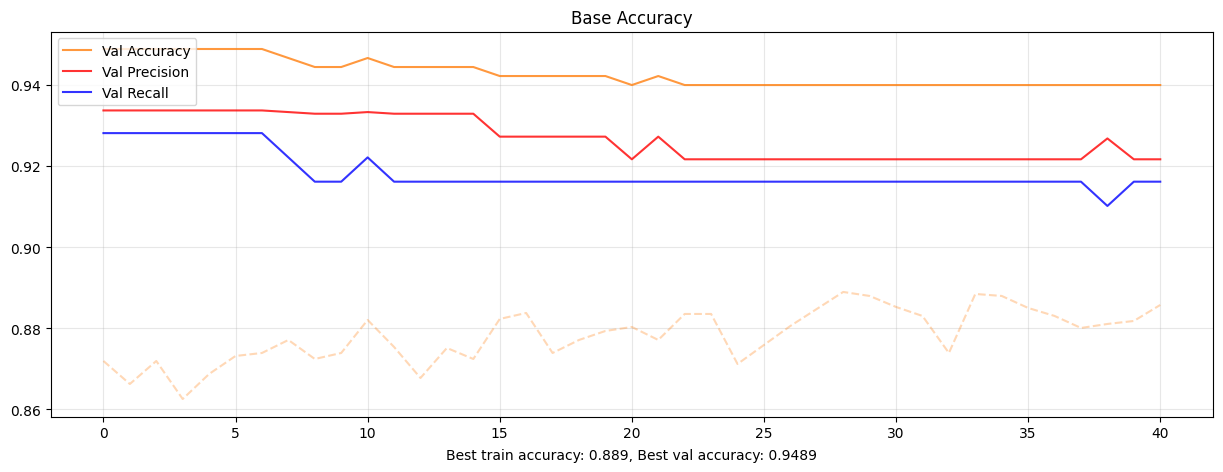

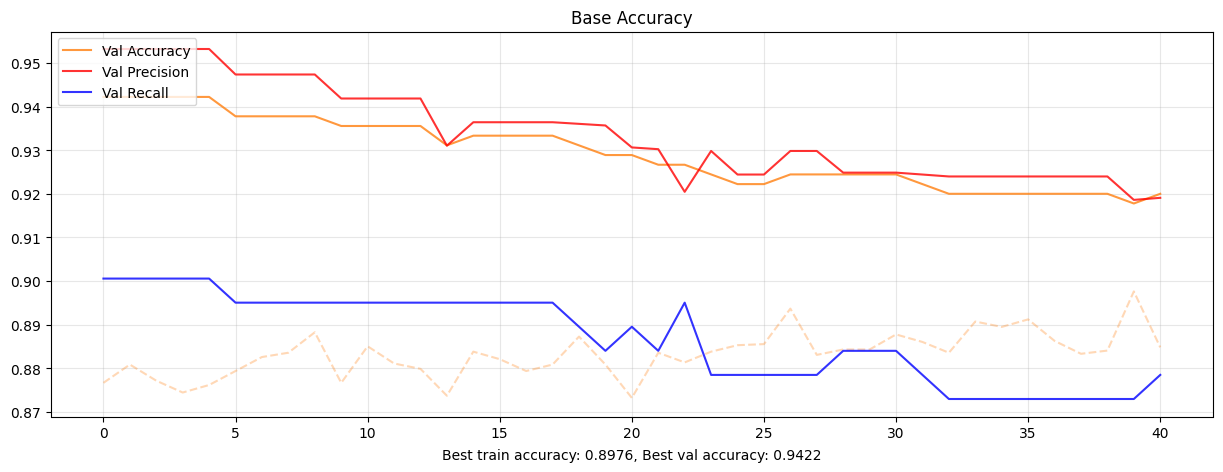

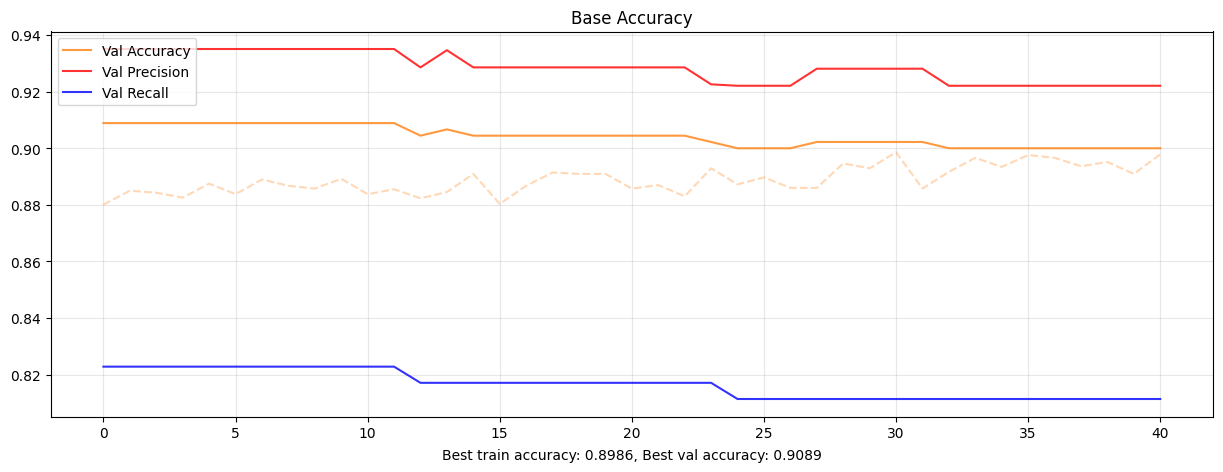

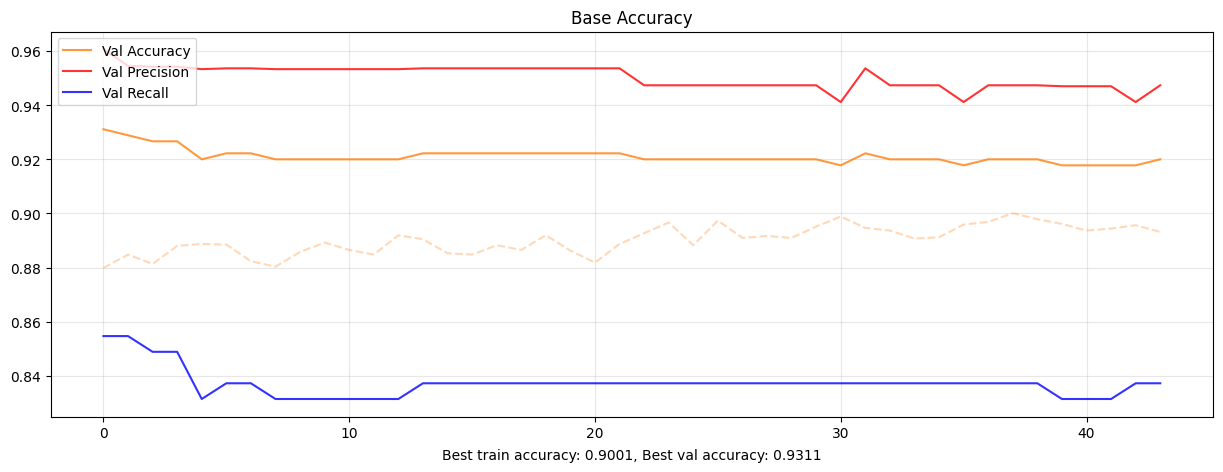

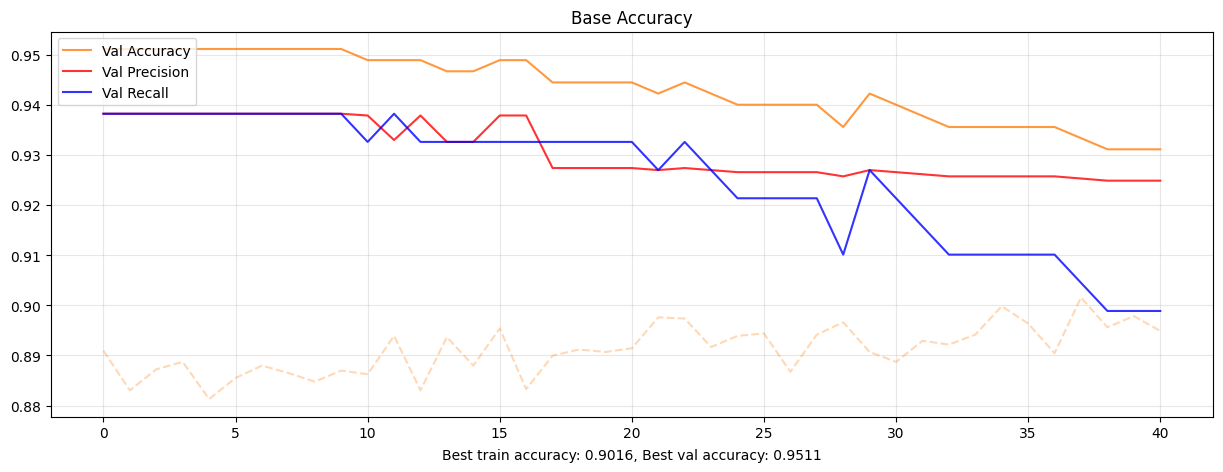

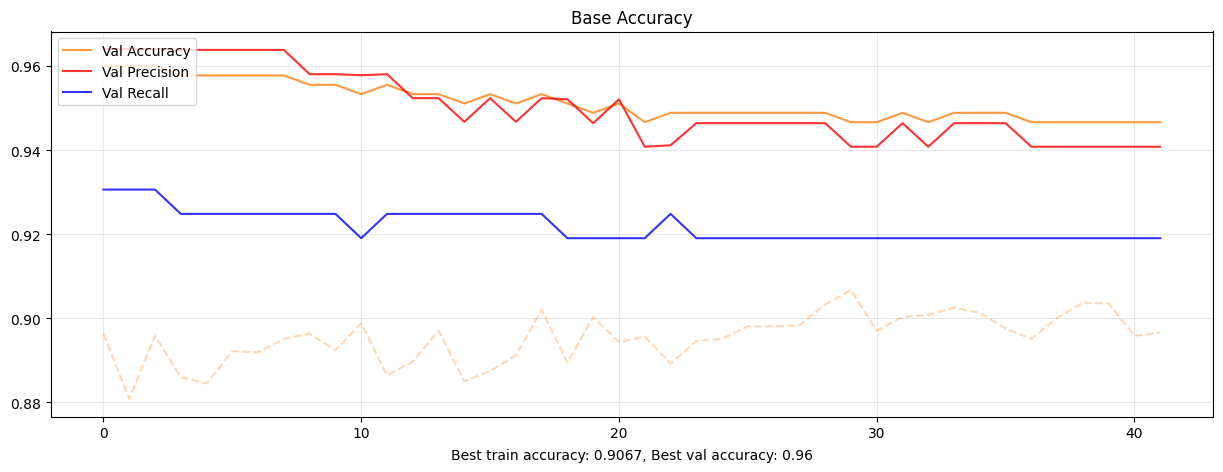

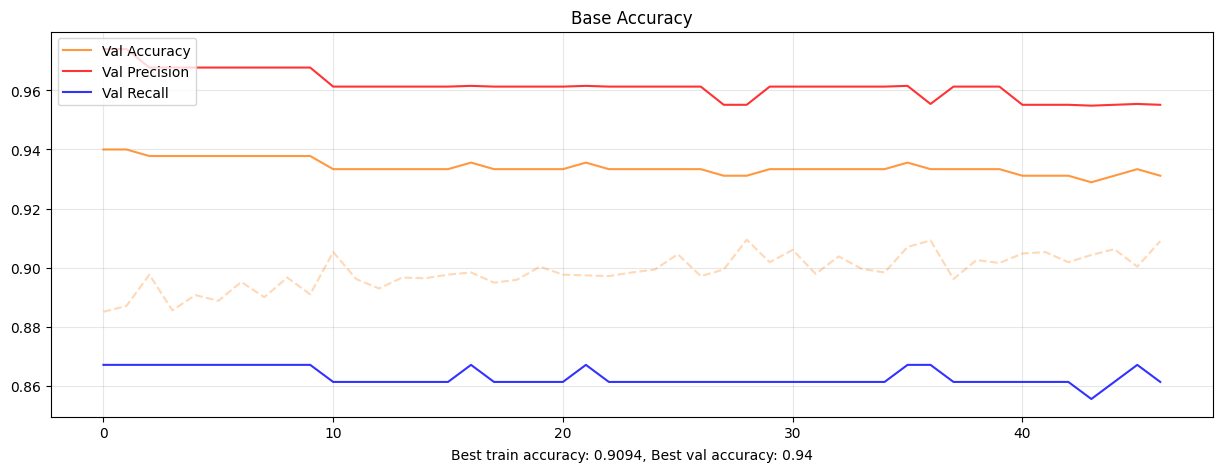

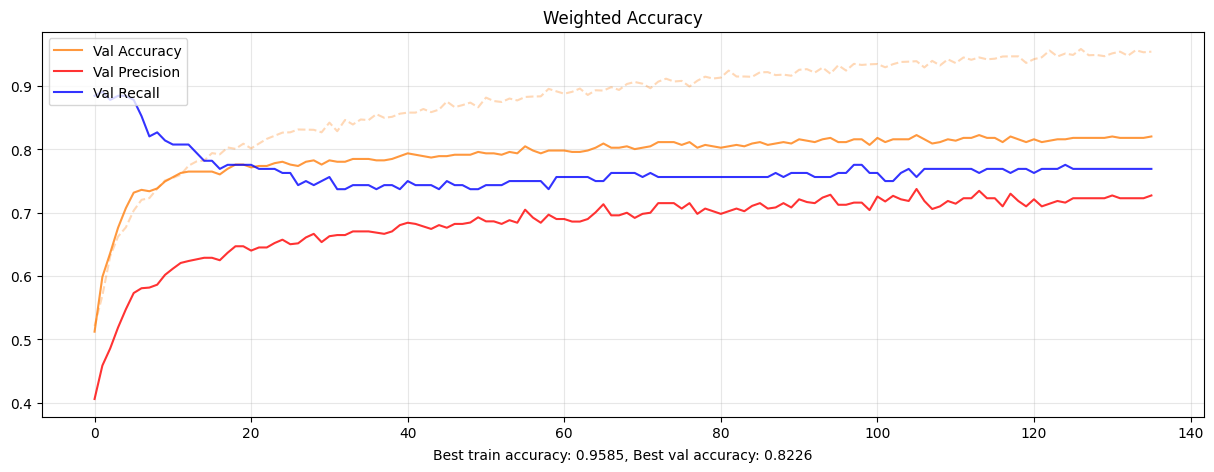

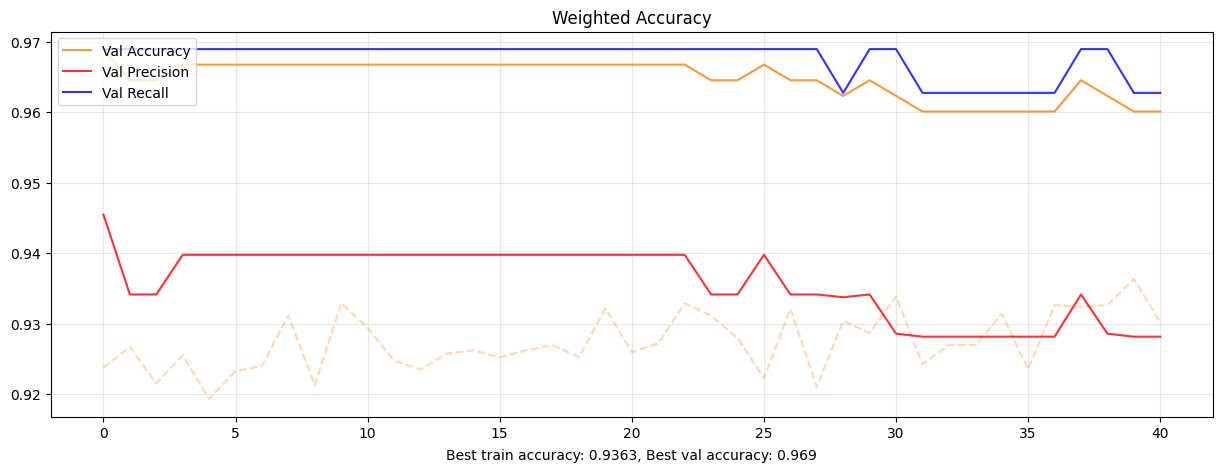

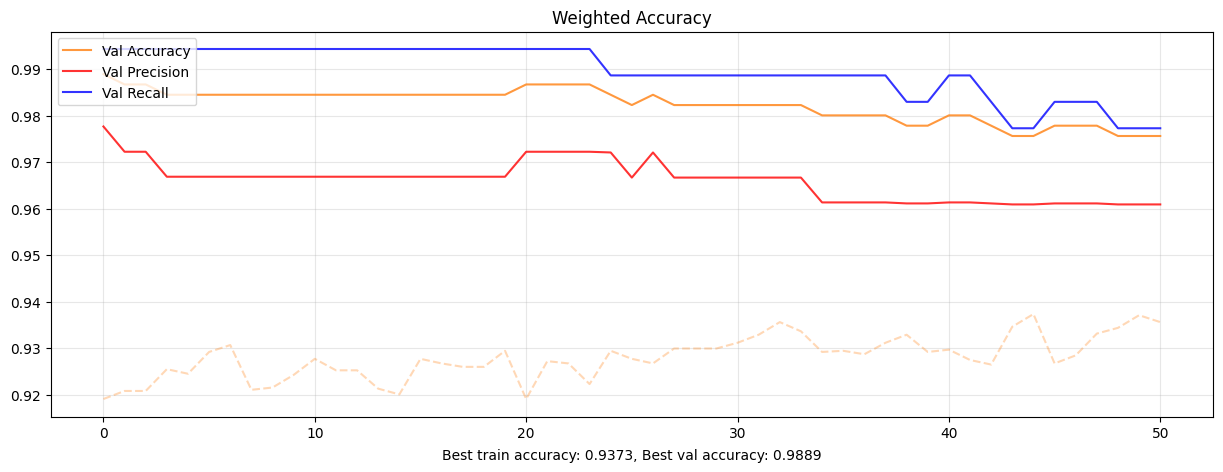

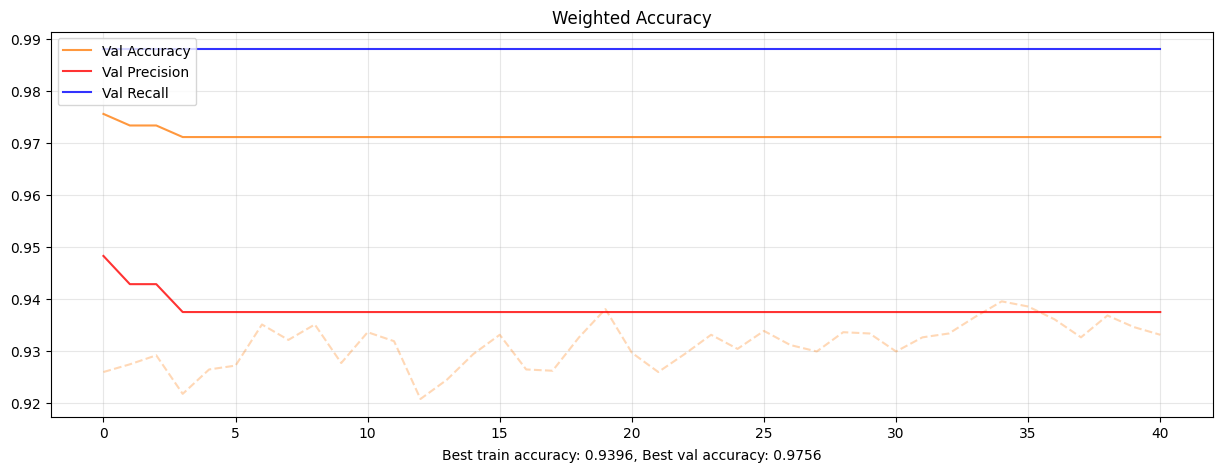

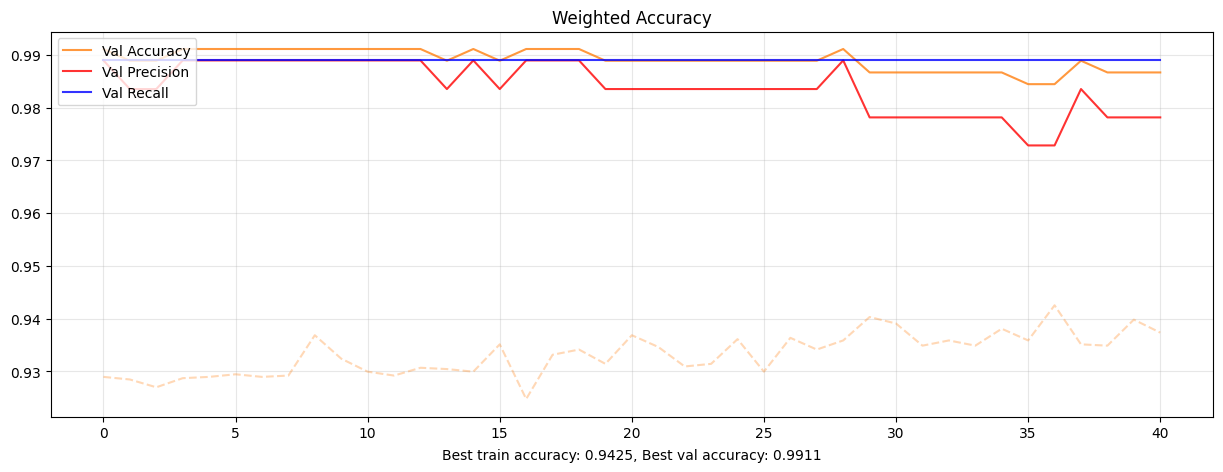

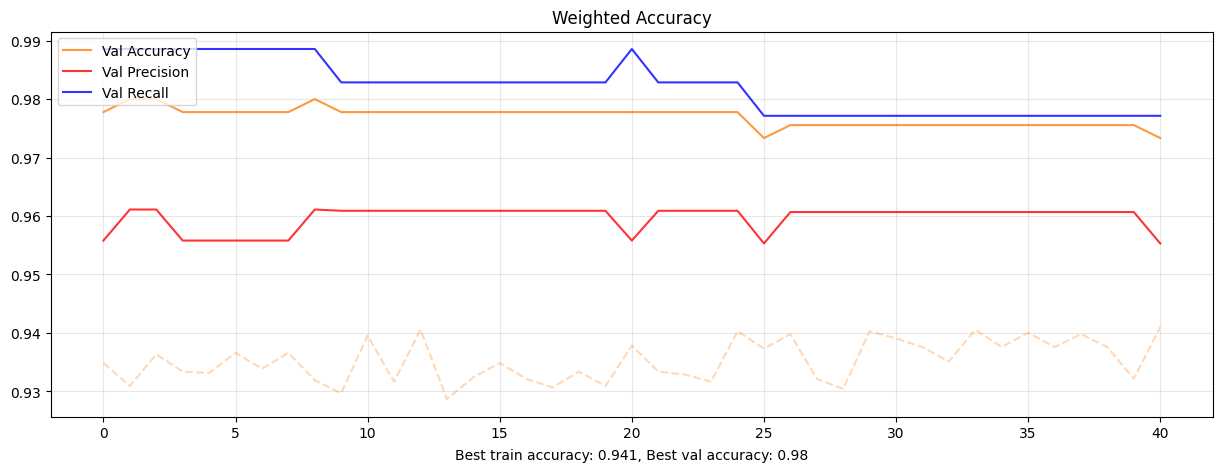

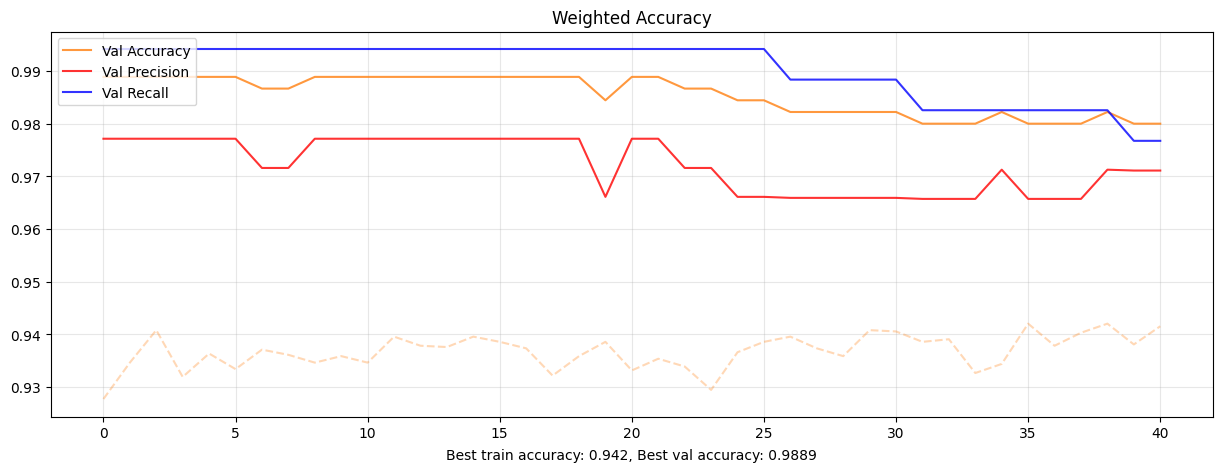

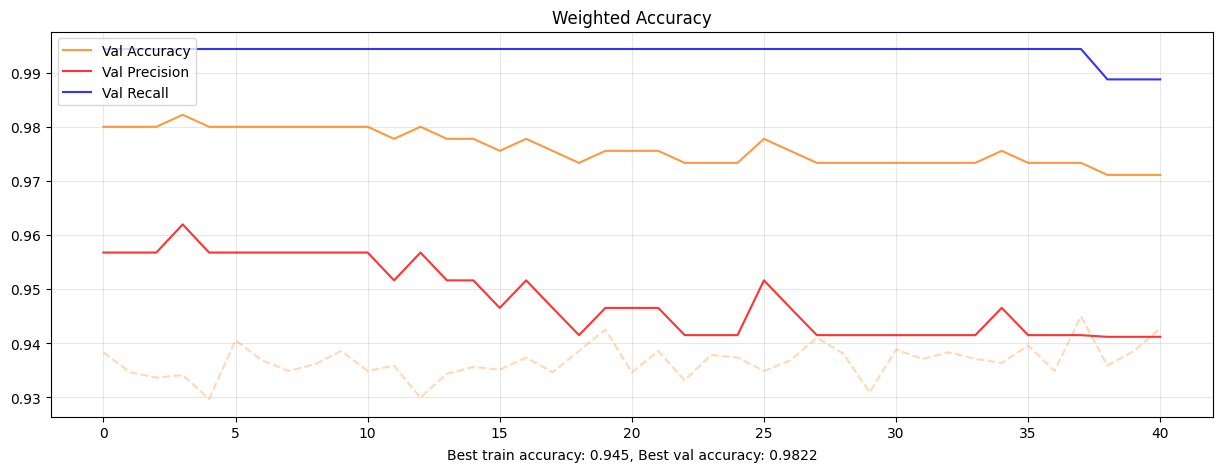

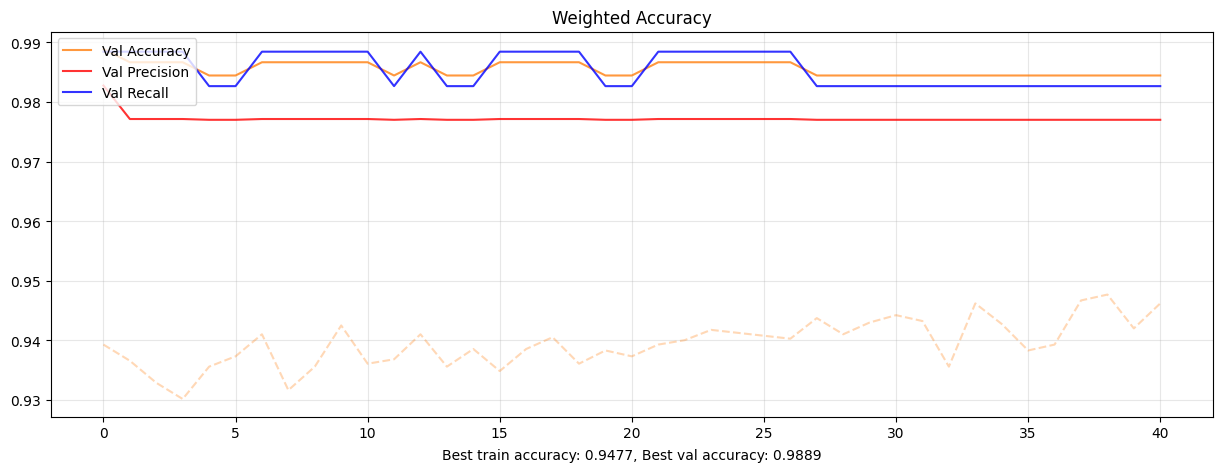

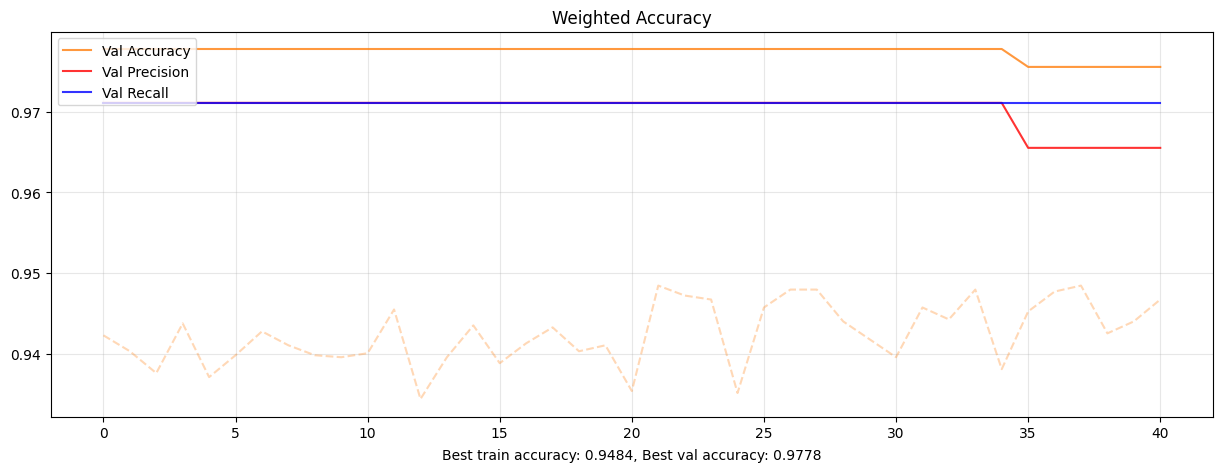

In [ ]:
for history in histories[0]:
  plot_history(history, "Base")
for history in histories[1]:
  plot_history(history, "Weighted")

### Fine Tuning

In [27]:
!rm -rf TransferLearningModel

In [28]:
model = models[1]
model.save("TransferLearningModel")
del model

In [5]:
def fine_tune(layers, learning_rate):
  model = tf.keras.models.load_model("TransferLearningModel")

  base_model = model.get_layer('efficientnetb2')

  base_model.trainable = False

  if (layers > 0):
    for i, layer in enumerate(base_model.layers[-layers:]):
      #if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True
      print(layer)

  for i in range(len(base_model.layers) - layers):
    if (base_model.layers[i].trainable):
      raise Exception("ERROR IN CONFIGURATION, FROZEN LAYERS ARE TRAINABLE")
  for i in range(len(base_model.layers) - layers, len(base_model.layers)):
    if (not base_model.layers[i].trainable and not isinstance(base_model.layers[i], tfkl.BatchNormalization)):
      raise Exception("ERROR IN CONFIGURATION, UNFROZEN LAYERS ARE NOT TRAINABLE")

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model

In [ ]:
histories = []


models = [
    fine_tune(0, 8e-6),
    fine_tune(4, 8e-6),
    fine_tune(10, 8e-6)
]


for i, model in enumerate(models):
  histories.append(
      model.fit(
        x = preprocess_input(X_train * 255),
        y = y_train,
        class_weight={
            0: weights[0],
            1: weights[1]
        },
        batch_size = 64,
        epochs = 200,
        validation_data = (preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True, start_from_epoch=5),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-6, mode='max')
        ]
  ).history)

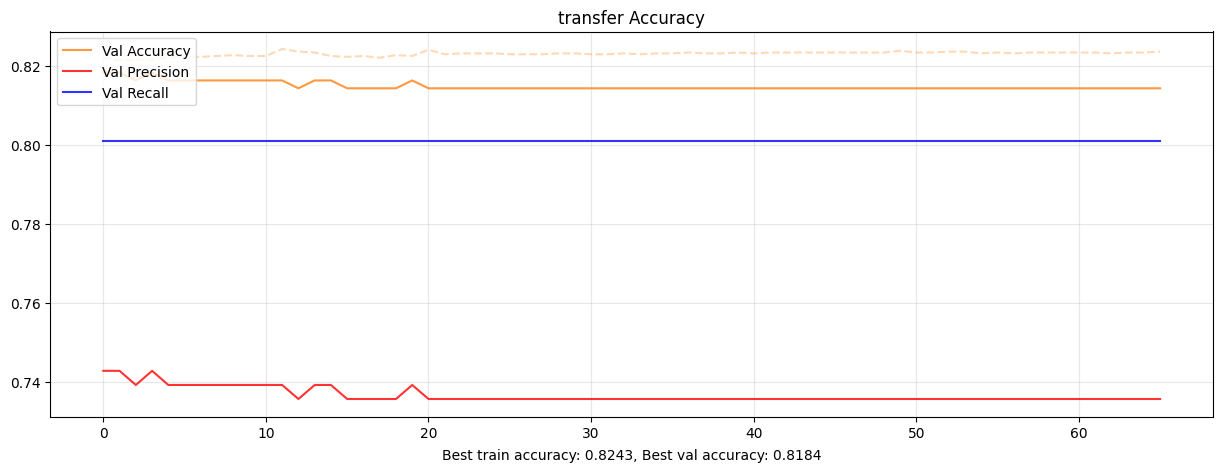

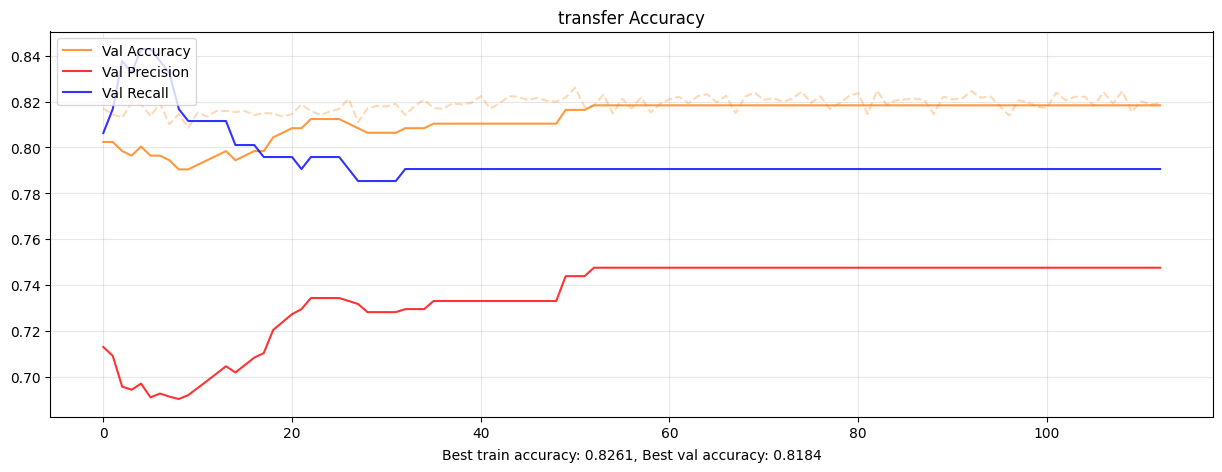

In [ ]:
for i, history in enumerate(histories):
  predictions = models[i].predict(preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  #print(classification_report(y_val, predictions))
  print(roc_auc)
  #print(len(history['val_accuracy']) - 20)
  print(history['val_accuracy'][-21])
  print(history['accuracy'][-21])
  plot_history(history, models[i].name)

In [ ]:
model.save("Submission")